In [19]:
import combining_representations as cr
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import pairwise_distances
from joblib import Parallel, delayed

from graspologic.embed import AdjacencySpectralEmbed as ASE
from graspologic.embed import LaplacianSpectralEmbed as LSE
from graspologic.simulations import rdpg
from graspologic.plot import pairplot

import seaborn as sns

from tqdm import tqdm

from time import time

In [3]:
def normalized_mean_reciprocal_rank(rank_lists, inds):
    """
    Calculates mean reciprocal rank given a rank list and set of indices of interest.
    
    Input
    rank_list - array-like (length=n-1)
        A ranked array-like of objects (assumed to be integers).
    inds - array-like (length<=n-1)
        A array-like of objects (assumed to be integers).
        
    Return
    mrr - float
        Mean reciprocal rank of the objects in inds.
    """
    mrrs = np.zeros(len(rank_lists))
    
    for i, r in enumerate(rank_lists):
        mrrs[i] = np.mean(1 / (np.array([np.where(r == s)[0][0] for s in inds])))
         
    return mrrs / np.mean(1 / np.arange(1, len(inds)+1))

In [24]:
def pairplot(X, labels=None, figsize=(10,10), alpha=0.7, linewidth=1, s=5, title=None, figaxs=None, **kwargs):
    """
    Improved pairplot function.

    """
    n_dims = X.shape[1]
    data = pd.DataFrame(X, columns=[f'{i}' for i in range(n_dims)])
    if labels is not None: 
        data['hue'] = list(labels)
        hue = 'hue'
    else: 
        hue=None
        
        
    if figaxs is None:
        fig, axs = plt.subplots(n_dims, n_dims,figsize=figsize)
    else:
        fig, axs = figaxs
        
    for i in range(n_dims): 
        for j in range(n_dims):
            ax = axs[i, j]
            if i == j:
                sns.kdeplot(data=data, x=f'{i}',  hue=hue, legend=False, ax=ax, linewidth=linewidth, alpha=alpha, palette="Set1", **kwargs)
                ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
            elif i < j:
                sns.scatterplot(data=data, x=f'{i}', y=f'{j}', hue=hue, legend=False, ax=ax, linewidth=linewidth, alpha=alpha,s=s, palette="Set1", **kwargs)
                ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
            else: 
                ax.axis('off')
                
    fig.suptitle(title)
                    
    return fig, axs

In [97]:
# Setting up hyperparameter for demo

# Number of vertices
n = 200

# Number of latent dimensions (i.e "true" dimensionality for ASE / LSE; really just for proof of concept stuff)
d=2

# Total number of queries we have access to. One of the queries will be the object we eventually want to rank things against
n_queries=5
colors = sns.color_palette("Set1", n_colors=n_queries)

# The beta distribution parameters used to generate the optimal linear combination. 
# When param1 = param2 then the distribution is centered at 0.5.
beta_distribution_parameters = (1e8, 1e8)

# S_star_size corresponds to the number of elements in the population that are "truly similar" to the vertex of interest
S_star_size=20

# Sk_size and S_size are the number of elements for each vertex that we know are "truly similar" to the vertex of interest.
# For vertices that are known similar to be similar to the vertex of interest we do not have a sense of order..
# i.e., conditioned on two vertices being similar to our vertex of interest, we don't know if vertex1 is "more similar" to the voi than vertex2 is to the voi.
Sk_size=3
S_size=3

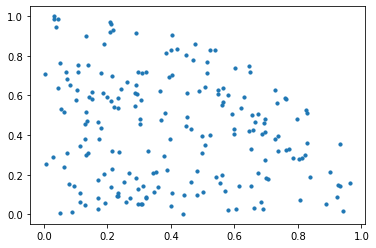

In [98]:
# Demo setting is just an RDPG with n nodes in d dimensions
np.random.seed(0)

X = generate_latent_positions(n, d)

fig, ax = plt.subplots(1,1)
ax.scatter(X[:, 0], X[:, 1], s=10)

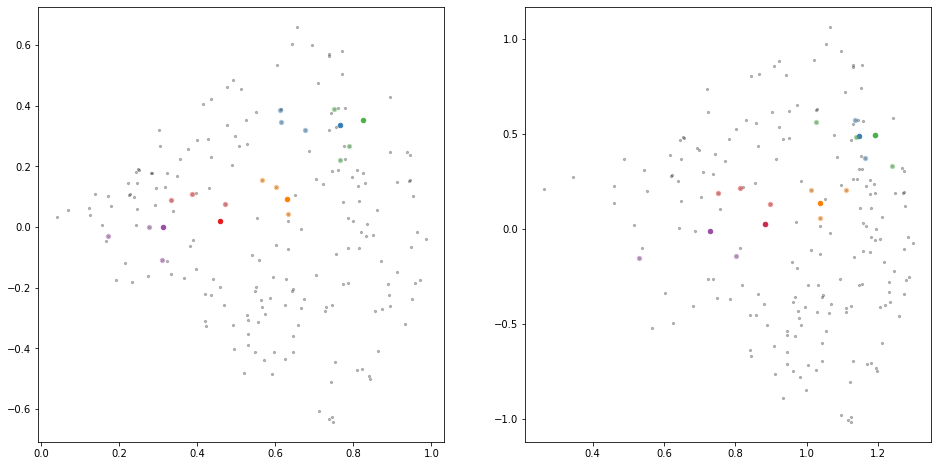

In [102]:
np.random.seed(0)

# A is just the adjacency matrix after taking the outer product of the latent positions
A = X @ X.T

# Two different transformations of the adjacency matrix
ase = ASE(n_components=d).fit_transform(A)
lse = np.sqrt(n) * LSE(n_components=d).fit_transform(A)

# Distance matrices for each of the different transformations.
# dist_matrices is an array of shape (n_transformations, n, n)
dist_matrices = np.array([pairwise_distances(emb) for emb in [ase, lse]])

# Here we just sample some vertices
vois = np.random.choice(n, n_queries, replace=False)

# We arbitrarily pick the first vertex to be our vertex of interest (i.e. we want to find a good ranking scheme for vstar)
vstar = vois[0]

# Sample the linear combinations
alphas = np.random.beta(*beta_distribution_parameters, size=5)

# Find the S_star_size number of vertices closest to vstar from the perspective of the linearly combined distances
S_star = generate_S_indices(dist_matrices[:, vstar].T, alphas[0], S_star_size)

# Take Sk_size of the elements from S_star to be known to be similar to vstar. The rest will be used for evaluation.
S = np.random.choice(S_star, Sk_size, replace=False)

fig, ax = plt.subplots(1,2, figsize=(16,8))

for i, emb in enumerate([ase, lse]):
    ax[i].scatter(emb[:, 0], emb[:, 1], alpha=0.25, s=5, c='k')
    for j, voi in enumerate(vois):
        if j > 0:
            S_ = np.random.choice(generate_S_indices(dist_matrices[:, voi].T, alphas[j], S_star_size), Sk_size, replace=False)
        else:
            S_ = S
        ax[i].scatter(emb[voi, 0], emb[voi, 1], color=colors[j], s=20)
        ax[i].scatter(emb[S_, 0], emb[S_, 1], color=colors[j],s=20,  alpha = 0.33)

In [103]:
eval_set = np.array([s for s in S_star if s not in S])

voi_to_S_set = {}
for i, voi in enumerate(vois):
    if voi == vstar:
        voi_to_S_set[voi] = S
    else:
        voi_to_S_set[voi] = np.random.choice(generate_S_indices(dist_matrices[:, voi].T, alphas[i], S_star_size), Sk_size, replace=False)

print(voi_to_S_set)

{18: array([ 64,  40, 120]), 170: array([100, 176,  79]), 107: array([172, 101, 110]), 98: array([175, 166, 120]), 177: array([ 18,  36, 153])}


In [104]:
temp_start = time()
alphahat_ilp = combine_representations(dist_matrices[:, vstar].T, vstar, S, False, variable_num_tol=None)
ilp_time = time() - temp_start

dist_ilp = np.average(dist_matrices, weights=alphahat_ilp, axis=0)[vstar]

temp_start = time()
alphahat_milp = multiple_pairs(dist_matrices, voi_to_S_set, variable_num_tol=None)
milp_time = time() - temp_start

dist_milp = np.average(dist_matrices, weights=alphahat_milp, axis=0)[vstar]

alphahat_average = 0.5 * alphahat_milp + 0.5 * alphahat_ilp
dist_average = np.average(dist_matrices, weights = alphahat_average, axis=0)[vstar]

ranks_no_S = remove_S_indices([np.argsort(dist_ilp), np.argsort(dist_milp), np.argsort(dist_average)], S)

tive)  in 0.000 seconds - new frequency is -100
Cbc0014I Cut generator 4 (OddWheel) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.000 seconds - new frequency is -100
Cbc0014I Cut generator 5 (MixedIntegerRounding2) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.000 seconds - new frequency is -100
Cbc0014I Cut generator 6 (FlowCover) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.000 seconds - new frequency is -100
Cbc0014I Cut generator 7 (TwoMirCuts) - 15 row cuts average 10.1 elements, 0 column cuts (0 active)  in 0.000 seconds - new frequency is 1
Cbc0001I Search completed - best objective 42, took 45 iterations and 0 nodes (0.02 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Total time (CPU seconds):       0.04   (Wallclock seconds):       0.04

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 28 (-561) rows, 15 (-183) columns and 56 (-1710) element

In [105]:
print(alphahat_ilp, alphahat_milp, alphahat_average)

[1. 0.] [0.63101571 0.36898429] [0.81550785 0.18449215]


In [106]:
mrrs = normalized_mean_reciprocal_rank(ranks_no_S, eval_set)
print(mrrs)

[0.97300782 0.99904988 0.99307773]
